In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 80516 (Erie, CO)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Erie = melted[melted.RegionName == 80516]
Erie = Erie.resample('MS').mean()
Erie = Erie.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

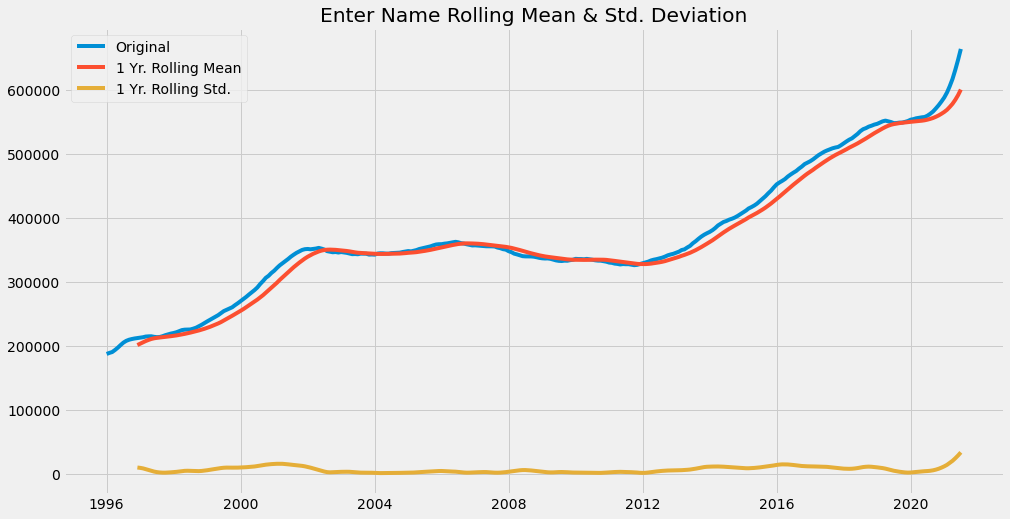

In [6]:
roll_mean_std(Erie)

### Seasonal Decompose

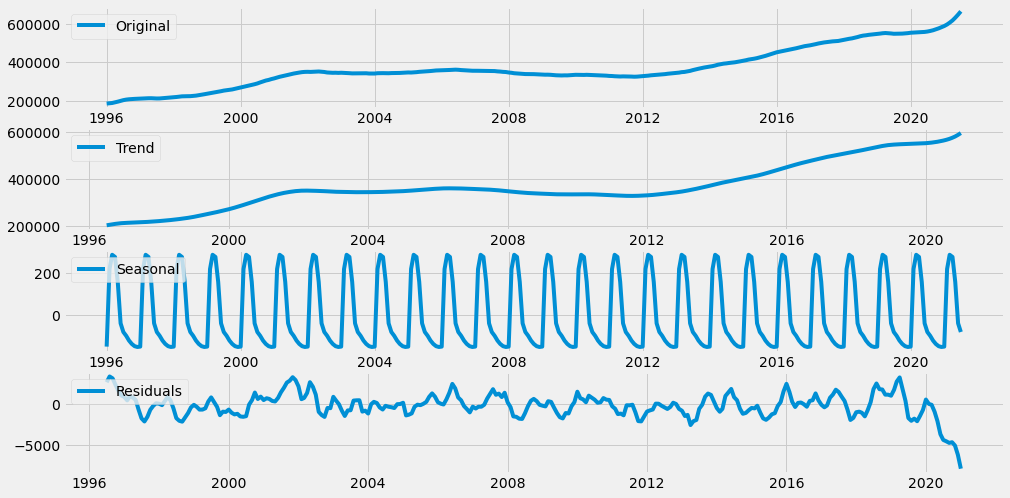

In [7]:
decompose(Erie)

### Differencing and DickeyFuller Test

In [8]:
DickeyFullerTest(Erie)

Test Statistic                   1.875683
p-value                          0.998488
# Lags Used                     16.000000
Number of Observations Used    290.000000
Critical Value (1%)             -3.453102
Critical Value (5%)             -2.871559
Critical Value (10%)            -2.572108
dtype: float64

Test Statistic                  -0.410042
p-value                          0.908409
# Lags Used                     16.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

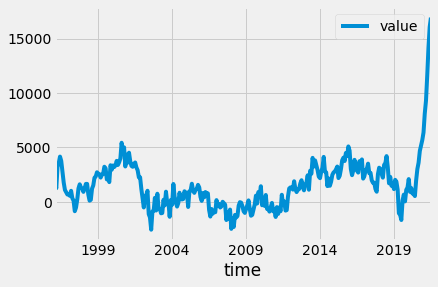

In [9]:
Erie_diff = Erie.diff().dropna()
Erie_diff.plot()
DickeyFullerTest(Erie_diff)

Test Statistic                  -0.766158
p-value                          0.828861
# Lags Used                     15.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64

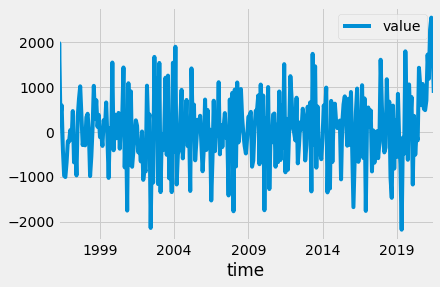

In [10]:
Erie_diff2 = Erie_diff.diff().dropna()
Erie_diff2.plot()
DickeyFullerTest(Erie_diff2)

### ACF and PACF

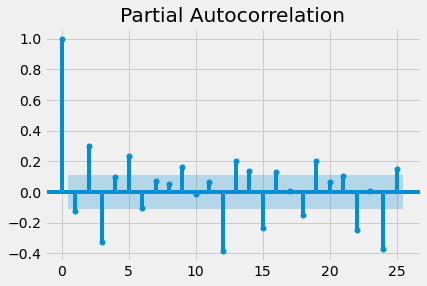

In [11]:
plot_pacf(Erie_diff2);

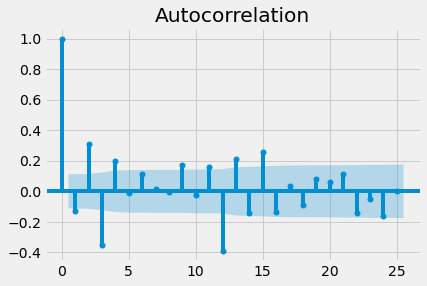

In [12]:
plot_acf(Erie_diff2);

### Train Test Split

In [13]:
cutoff = round(Erie.shape[0]*.8)
train = Erie[:cutoff]
test = Erie[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 2054.04
The Naive Model RMSE for the test data is: 4861.81


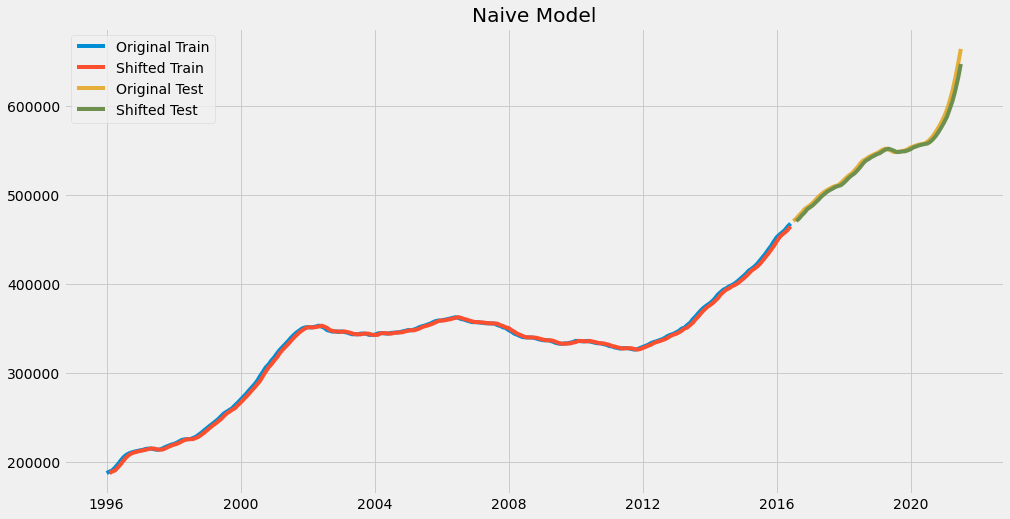

In [14]:
naive_model(train, test)

### Random Walk

In [15]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

2054.04390192138

### Auto ARIMA

In [16]:
auto_Jacksonville = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3921.011, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3924.345, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3923.528, Time=0.16 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3921.716, Time=0.17 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3921.677, Time=0.21 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3923.084, Time=0.91 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3923.955, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3922.952, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3921.629, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=3922.991, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.953 seconds


In [17]:
sarimax_model = SARIMAX(train, order=(2,1,0), seasonal_order=(0,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[2:], yhat_train[2:]))
RMSE

1655.0226148238319

### SARIMAX GridSearch and Model

In [18]:
sarimax_search(train, p=range(1,3), d=range(1,3), q=range(1,2), maxiter=100)

THERE ARE 16 ITERATIONS
Would you like to run the models? (y or n)?y
SARIMAX (1, 1, 1) x (1, 1, 1, 12) - RMSE:14926.802578498484
SARIMAX (1, 1, 1) x (1, 2, 1, 12) - RMSE:19247.459343479495
SARIMAX (1, 1, 1) x (2, 1, 1, 12) - RMSE:15127.054352433403
SARIMAX (1, 1, 1) x (2, 2, 1, 12) - RMSE:18803.775148724322
SARIMAX (1, 2, 1) x (1, 1, 1, 12) - RMSE:15680.45147818579
SARIMAX (1, 2, 1) x (1, 2, 1, 12) - RMSE:21791.85667203186
SARIMAX (1, 2, 1) x (2, 1, 1, 12) - RMSE:15713.845188206056
SARIMAX (1, 2, 1) x (2, 2, 1, 12) - RMSE:19012.239449988923
SARIMAX (2, 1, 1) x (1, 1, 1, 12) - RMSE:14911.430052430042
SARIMAX (2, 1, 1) x (1, 2, 1, 12) - RMSE:21111.013501147165
SARIMAX (2, 1, 1) x (2, 1, 1, 12) - RMSE:14711.671005735132
SARIMAX (2, 1, 1) x (2, 2, 1, 12) - RMSE:18379.78513269134
SARIMAX (2, 2, 1) x (1, 1, 1, 12) - RMSE:15921.712071034015
SARIMAX (2, 2, 1) x (1, 2, 1, 12) - RMSE:20300.389817374577
SARIMAX (2, 2, 1) x (2, 1, 1, 12) - RMSE:15862.100861201945
SARIMAX (2, 2, 1) x (2, 2, 1, 12) 

### Facebook Prophet Model

In [19]:
Erie_proph = Erie.reset_index()
Erie_proph = Erie_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 2494.409735335084
%RMSE:  y    0.006742
dtype: float64


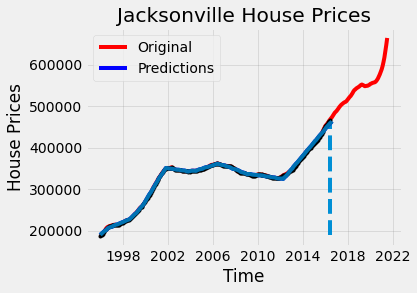

In [20]:
fbprophet_func(Erie_proph, periods=2, city = 'Jacksonville')

### LSTM Model

In [21]:
history = LSTM_func(Erie_proph, City='Erie', epochs=200, verbose = 0, use_multiprocessing=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
RMSE: 7139.261939055337
%RMSE:  1940.296037209777


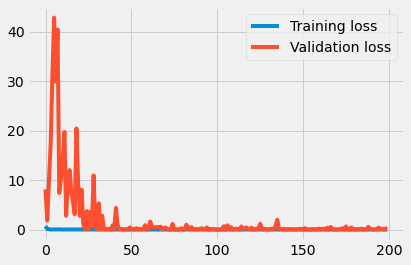

In [22]:
LSTM_val(history)

# Best Model

#### Will now try and predict the value of houes 1 year from now using Prophet.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


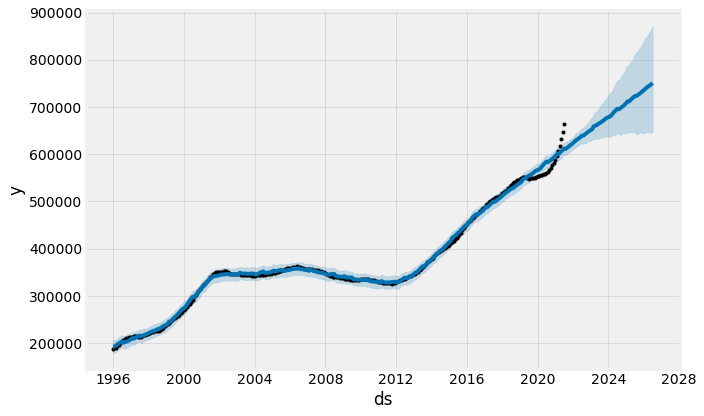

In [23]:
final_model = Prophet(interval_width=.95)
final_model.fit(Erie_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

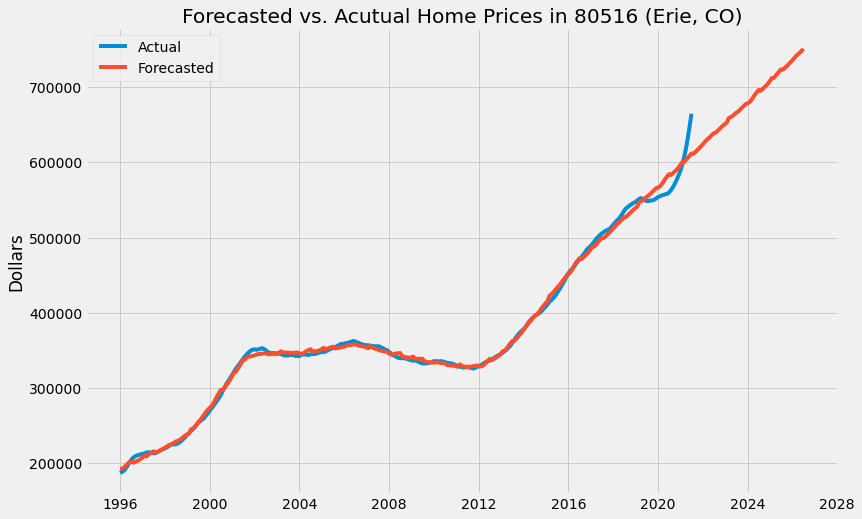

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Erie_proph.ds, Erie_proph.y, label='Actual')
ax.plot(forecast.ds, forecast.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 80516 (Erie, CO)')
ax.set_ylabel('Dollars')
ax.legend();

In [25]:
current_price = int(Erie_proph[Erie_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $664721
Predicted 2026 price:         $750797
Predicted five year increase: $86076
Predicted five year ROI:      0.12949192217486735
